First, let's import all the neccesary packages

In [1]:
import os 
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import torch
import numpy as np
from hydra import compose, initialize
from omegaconf import DictConfig, OmegaConf
from torch_geometric.data import Data
from utils import encode_to_PGA, extract_from_PGA
from train import Trainer

/home/ubuntu/miniforge3/envs/JHL_env/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/ubuntu/miniforge3/envs/JHL_env/lib/python3.11/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/ubuntu/miniforge3/envs/JHL_env/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/ubuntu/miniforge3/envs/JHL_env/lib/python3.11/site-packages/libpyg.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


We can then set up the basics

In [2]:
#device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") # change GPU depending on the run

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Hydra 초기화 및 구성 로드
initialize(config_path="config", version_base="1.1")
cfg = compose(config_name="config.yaml")

# 구성 확인
print(OmegaConf.to_yaml(cfg))

experiment:
  seed: 36
  device: cuda:2
  wandb: false
  wandb_api_key: ''
  wandb_project_name: SimJEB_GATr_mk2
dataset:
  data_dir: /data/SimJEB/
  max_epochs: 200
  train_sample_id:
  - 21
  - 30
  - 38
  - 62
  - 8
  - 9
  - 15
  - 23
  - 6
  - 10
  - 22
  - 63
  - 14
  - 29
  - 35
  - 40
  - 19
  - 27
  - 28
  - 33
  valid_sample_id:
  - 20
  - 4
  - 0
  - 12
  - 16
arch:
  encoder:
    in_mv_channel: 1
    in_s_channel: 2
  processor:
    hidden_mv_channel: 8
    hidden_s_channel: 64
    n_layers_gatr: 3
    n_mlp_per_gatr: 3
    n_attn_heads: 1
  decoder:
    out_mv_channel: 1
    out_s_channel: 1
scheduler:
  initial_lr: 0.001
  weight_decay: 0.0



The next code block is for testing the encoder and the decoder that turns the graph data into PGA multivector data

In [3]:
trainer = Trainer(cfg, shuffle=False)

# Let's first test a very simple graph and see how it handles it

x = torch.tensor([
        [1,2,3,   4,5,6,   7,8,9],
        [9,8,7,   6,5,4,   3,2,1],
        [10,10,10,2,3,4,   4,5,6]
    ], dtype=torch.float)

bc = torch.tensor([
        [0,0],
        [1,0],
        [0,1]
    ], dtype=torch.float)

edge_index = torch.tensor([
        [0, 0],
        [1, 2]
    ], dtype=torch.long)

force = torch.tensor([
    [1,2,1],
    [1,2,1],
    [1,2,1]
])
# bc = torch.cat([force, bc], dim = -1)

graph = Data(x=x, bc=bc, edge_index=edge_index)
graph = graph.to(trainer.device)


[train] sample_idx: 21 | shape of input: torch.Size([36544, 9]) | shape of bc: torch.Size([36544, 2])
[train] sample_idx: 30 | shape of input: torch.Size([21906, 9]) | shape of bc: torch.Size([21906, 2])
[train] sample_idx: 38 | shape of input: torch.Size([58270, 9]) | shape of bc: torch.Size([58270, 2])
[train] sample_idx: 62 | shape of input: torch.Size([28832, 9]) | shape of bc: torch.Size([28832, 2])
[train] sample_idx:  8 | shape of input: torch.Size([60068, 9]) | shape of bc: torch.Size([60068, 2])
[train] sample_idx:  9 | shape of input: torch.Size([97030, 9]) | shape of bc: torch.Size([97030, 2])
[train] sample_idx: 15 | shape of input: torch.Size([46732, 9]) | shape of bc: torch.Size([46732, 2])
[train] sample_idx: 23 | shape of input: torch.Size([43350, 9]) | shape of bc: torch.Size([43350, 2])
[train] sample_idx:  6 | shape of input: torch.Size([68746, 9]) | shape of bc: torch.Size([68746, 2])
[train] sample_idx: 10 | shape of input: torch.Size([86471, 9]) | shape of bc: tor

In [4]:
print("Original graph node features (x):\n", graph.x)
print("Original graph boundary cond (bc):\n", graph.bc)
print("Edge index:\n", graph.edge_index, "\n")

encoded_multivector, encoded_scalar = encode_to_PGA(graph)
print("Encoded multivector shape:", encoded_multivector.shape)
print("Encoded multivector (squeezed):\n", encoded_multivector.squeeze(0).squeeze(1), "\n")

decoded_graph = extract_from_PGA(encoded_multivector, encoded_scalar, graph)
print("Decoded graph node features (x):\n", decoded_graph.x)
print("Decoded graph boundary cond (bc):\n", decoded_graph.bc)


Original graph node features (x):
 tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.],
        [10., 10., 10.,  2.,  3.,  4.,  4.,  5.,  6.]], device='cuda:2')
Original graph boundary cond (bc):
 tensor([[0., 0.],
        [1., 0.],
        [0., 1.]], device='cuda:2')
Edge index:
 tensor([[0, 0],
        [1, 2]], device='cuda:2') 

Encoded multivector shape: torch.Size([1, 3, 1, 16])
Encoded multivector (squeezed):
 tensor([[   0.,  -50.,    7.,    8.,    9.,   -3.,    6.,   -3.,    6.,   -5.,
            4.,   -3.,    2.,   -1.,    1.,    0.],
        [   0.,  -50.,    3.,    2.,    1.,   -3.,    6.,   -3.,    4.,   -5.,
            6.,   -7.,    8.,   -9.,    1.,    0.],
        [   0., -150.,    4.,    5.,    6.,   10.,  -20.,   10.,    4.,   -3.,
            2.,  -10.,   10.,  -10.,    1.,    0.]], device='cuda:2') 

Decoded graph node features (x):
 tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [ 9.,  8.,  7

Let's then test the forward pass of the GATr network

In [5]:
trainer.make_model_components(cfg)
# trainer.model.to(trainer.device)

with torch.no_grad():
    output = trainer.model(graph)
    print("Output features (x):", output.x)
    print("Output boundary condition:", output.bc)

Output features (x): tensor([[-4.5966, -4.9945, -5.3924, -0.0650, -0.0810, -0.0970, -0.1153, -0.1312,
         -0.1478],
        [ 0.5383,  0.9344,  1.3311, -0.2298, -0.1965, -0.1628, -0.0524, -0.0435,
         -0.0368],
        [ 7.2332,  5.8457,  4.4582, -0.0293, -0.0422, -0.0551, -0.0751, -0.0912,
         -0.1111]], device='cuda:2')
Output boundary condition: tensor([[0.4056],
        [0.0795],
        [0.9868]], device='cuda:2')


Let's now test the ability to do forward pass with our dataset

In [6]:

with torch.no_grad():
    for graph in trainer.train_loader:
        graph = graph.to(trainer.device)
        output = trainer.model(graph)
        print("Output graph dimension:", output.x.shape)
        print("Output bc dimension", output.bc.shape)

Output graph dimension: torch.Size([36544, 9])
Output bc dimension torch.Size([36544, 1])
Output graph dimension: torch.Size([21906, 9])
Output bc dimension torch.Size([21906, 1])
Output graph dimension: torch.Size([58270, 9])
Output bc dimension torch.Size([58270, 1])
Output graph dimension: torch.Size([28832, 9])
Output bc dimension torch.Size([28832, 1])
Output graph dimension: torch.Size([60068, 9])
Output bc dimension torch.Size([60068, 1])
Output graph dimension: torch.Size([97030, 9])
Output bc dimension torch.Size([97030, 1])
Output graph dimension: torch.Size([46732, 9])
Output bc dimension torch.Size([46732, 1])
Output graph dimension: torch.Size([43350, 9])
Output bc dimension torch.Size([43350, 1])
Output graph dimension: torch.Size([68746, 9])
Output bc dimension torch.Size([68746, 1])
Output graph dimension: torch.Size([86471, 9])
Output bc dimension torch.Size([86471, 1])
Output graph dimension: torch.Size([75949, 9])
Output bc dimension torch.Size([75949, 1])
Output gra

In [6]:
# training 

trainer.train(cfg)

Epoch [   1/3000] | Train Loss: 1.071842 | Val Loss: 0.485066 | LR: 5e-04
Epoch [   2/3000] | Train Loss: 1.018076 | Val Loss: 0.585625 | LR: 5e-04


KeyboardInterrupt: 

Let's now test the learned model

(57168, 1)
(57168, 1)


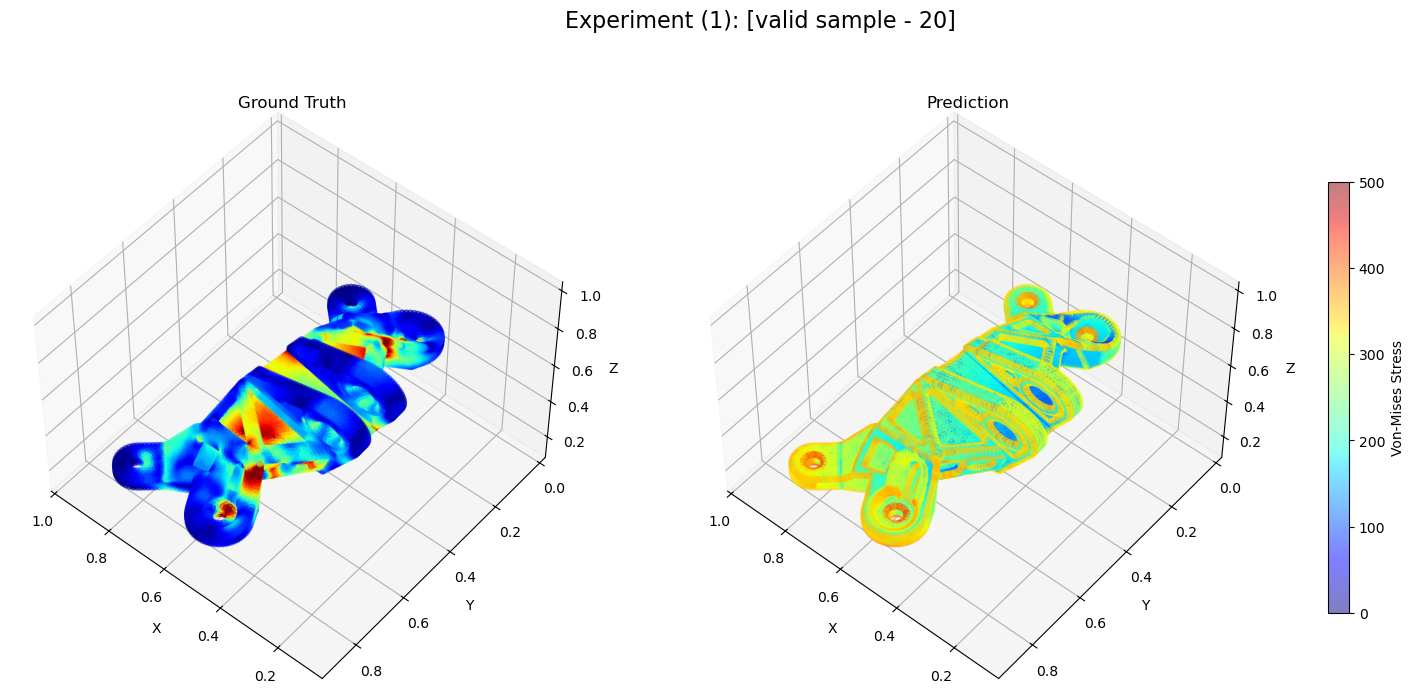

(87908, 1)
(87908, 1)


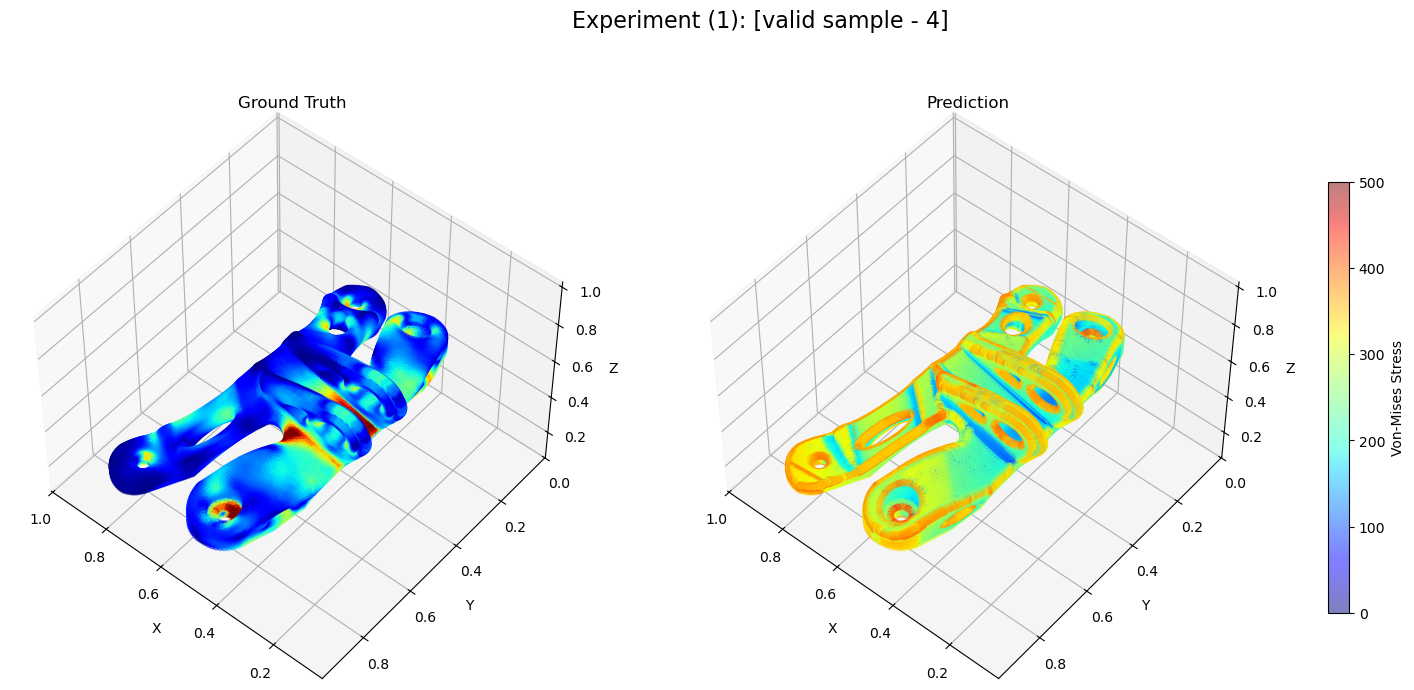

(112873, 1)
(112873, 1)


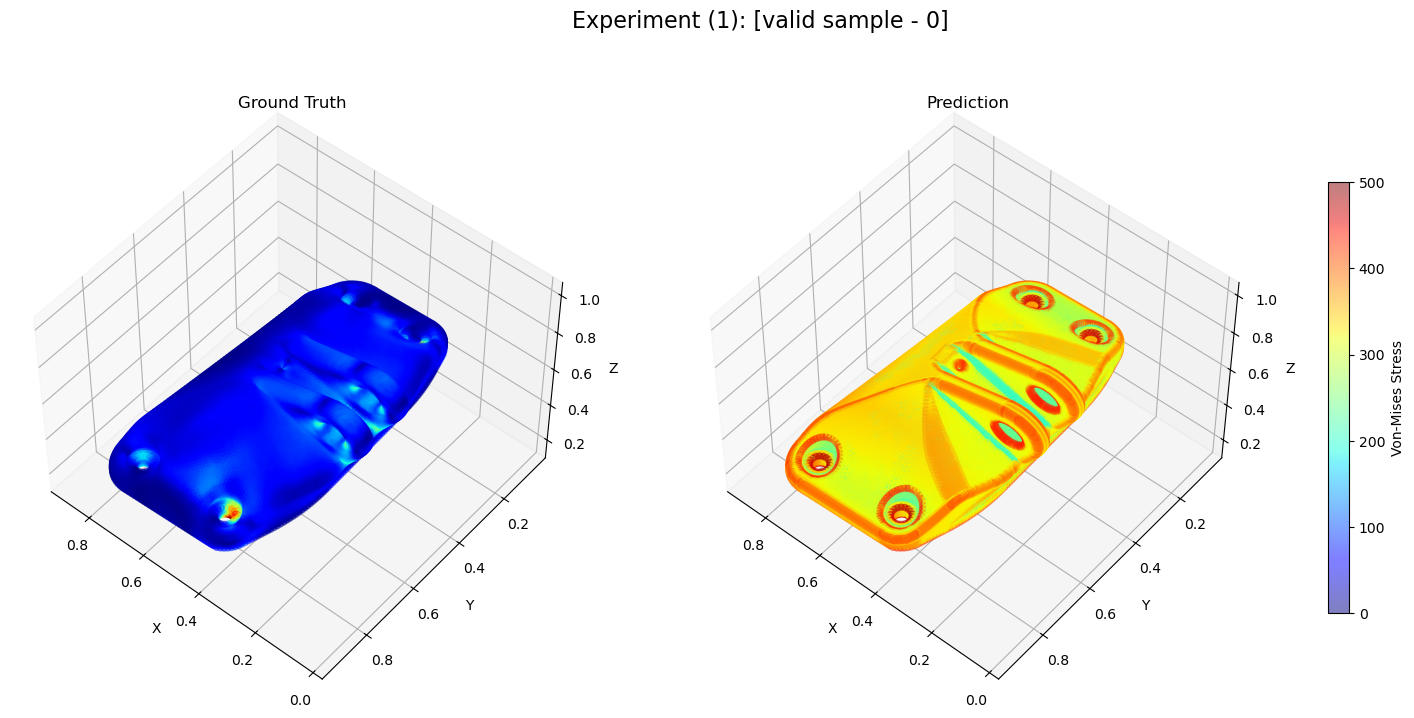

(123939, 1)
(123939, 1)


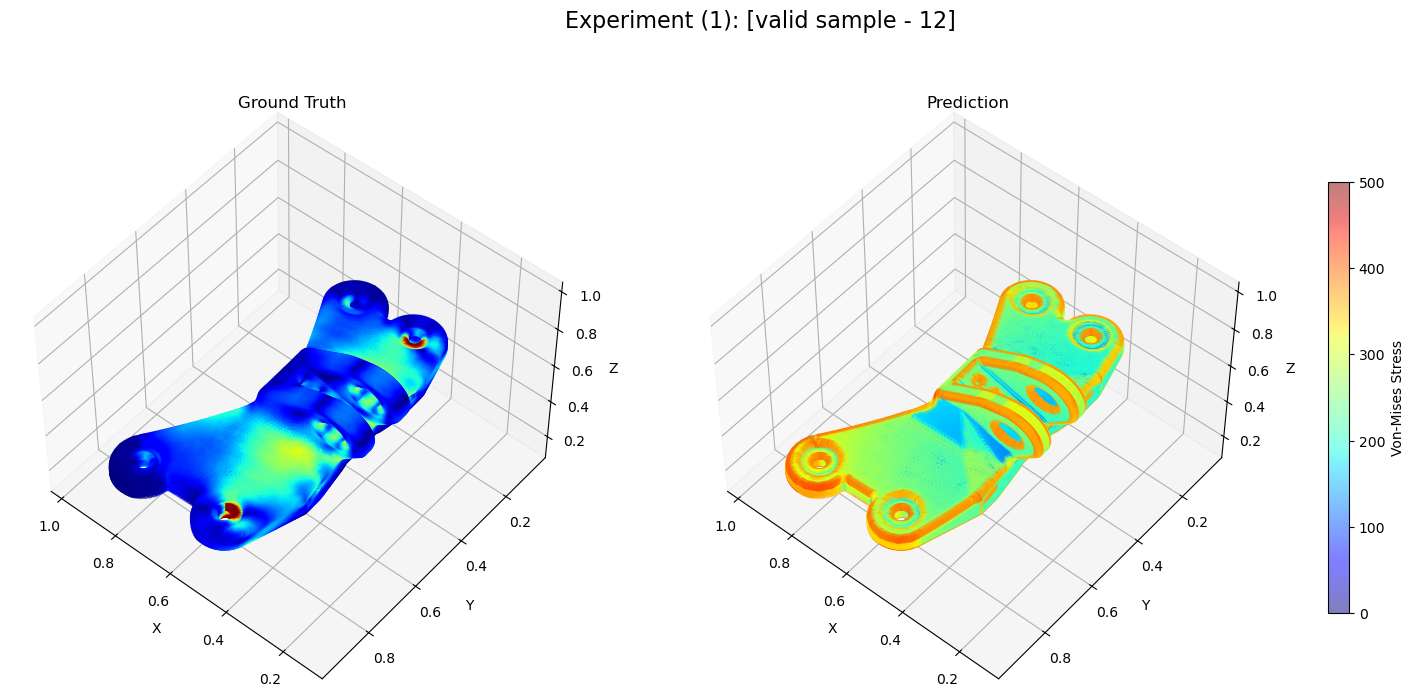

(62273, 1)
(62273, 1)


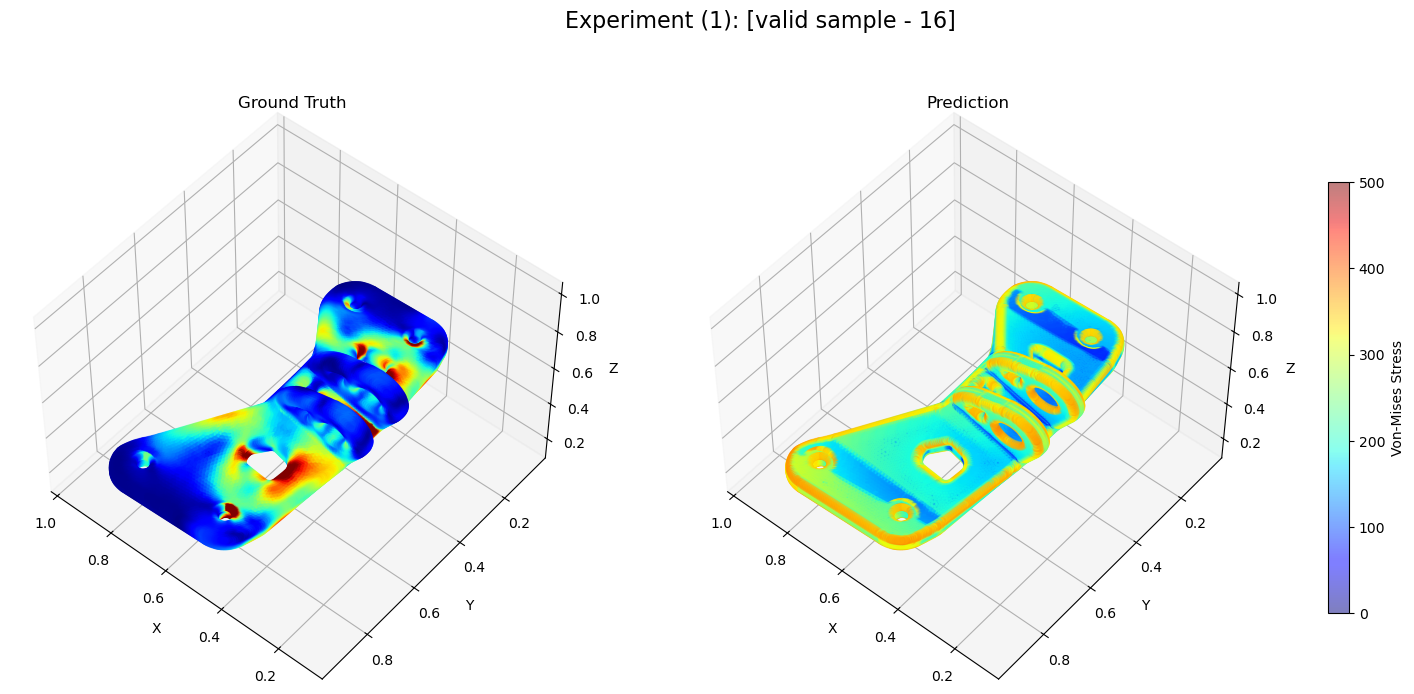

In [ ]:
from gatr.interface import (
    embed_point,
    embed_scalar,
    embed_pluecker_ray,
    embed_oriented_plane,
    embed_translation,
    extract_scalar,
    extract_point,
    extract_pluecker_ray,
    extract_oriented_plane,
    extract_point_embedding_reg,
)

vmin = 0
vmax = 500
cmap = 'jet'

valid_sample_id_smallver = [20, 4, 0, 12, 16]

# This is a temporary part because I changed the model architecture and the old stuff is incompatible

def extract_from_PGA(multivector, scalar, base_graph):
    """
    Takes the multivector and returns is back to the graph data form 

    Parameters
    ----------
    inputs: torch.Tensor with shape (1, objects, 1, 16)
                The multivector to be decoded
            torch.Tensor with shape (1, objects, 2)
                The scalar to be decoded
            base_graph: torch_geometric.data.Data
                The base graph data that contains edge information, ground truth etc.

    returns
    -------
    graph_data: torch_geometric.data.Data
        The graph data
    """

    # Remove the channel and batch_size dimensions
    multivector = multivector.squeeze(0).squeeze(1)
    scalar = scalar.squeeze(0)

    # Extract the data from the multivector
    pos = extract_point(multivector) # Extract the position from the trivector, (objects, 3)
    curv = extract_pluecker_ray(multivector) # Extract the curvature from the bivector, (objects, 6)
    curv = curv[:, :3] # The last three elements are the position, so we remove them
    norm = extract_oriented_plane(multivector) # Extract the normal from the vector, (objects, 3)
    bc = scalar
    #bc = extract_scalar(multivector) # Extract the scalar component, which for now is the predicted stress (objectss, 1)

    # BC not encoded in multivector anymore
    # bc = extract_scalar(multivector) # Extract the BC from the scalar, (objects, 1)
    # bc = torch.cat([torch.nn.functional.relu(bc), torch.nn.functional.relu(-bc)], dim=1) # Decode the BC back to the original form, (objects, 2)

    x = torch.cat([pos, curv, norm], dim=-1) # (objects, 9)

    result_graph = Data(x = x, bc = bc, edge_index = base_graph.edge_index, y = base_graph.y)

    return result_graph

filename = "./outputs/2025-03-25/22-28-44/ckpt/best_valid_loss.pt"
ckpt = torch.load(filename)

trainer.load_model(ckpt = ckpt)

trainer.model.eval()

with torch.no_grad():
    for index, graph in enumerate(trainer.valid_loader):

        graph = graph.to(trainer.device)
        pred = trainer.model(graph)
        pred = pred.bc
        y = graph.y
        coords = graph.x[:, :3] # 좌표값 추출

        pred = pred * (trainer.target_std) + trainer.target_mean
        y = y * (trainer.target_std) + trainer.target_mean
        #coords = coords * (trainer.coords_max - trainer.coords_min) + trainer.coords_min

        pred_numpy = pred.to("cpu").detach().numpy()
        y_numpy = y.to("cpu").detach().numpy()
        coords_numpy = coords.to("cpu").detach().numpy()

        print(pred_numpy.shape)
        print(y_numpy.shape)

        # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
        x_min, x_max = coords_numpy[:, 0].min(), coords_numpy[:, 0].max()
        y_min, y_max = coords_numpy[:, 1].min(), coords_numpy[:, 1].max()
        z_min, z_max = coords_numpy[:, 2].min(), coords_numpy[:, 2].max()

        # 각 축의 중심과 범위를 맞추기 위한 설정
        max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

        mid_x = (x_max + x_min) * 0.5
        mid_y = (y_max + y_min) * 0.5
        mid_z = (z_max + z_min) * 0.5

        # 3D 그래프 준비
        fig = plt.figure(figsize=(20, 8))

        # y (Ground Truth) 그래프
        ax_gt = fig.add_subplot(1, 2, 1, projection='3d')
        sc_gt = ax_gt.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=y_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_gt.set_title(f'Ground Truth')

        # 동일한 비율로 축 설정
        ax_gt.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_gt.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_gt.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_gt.set_xlabel('X')
        ax_gt.set_ylabel('Y')
        ax_gt.set_zlabel('Z')
        ax_gt.view_init(elev = 50, azim = 130)

        # pred (Prediction) 그래프
        ax_pred = fig.add_subplot(1, 2, 2, projection='3d')
        sc_pred = ax_pred.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=pred_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
        ax_pred.set_title(f'Prediction')

        # 동일한 비율로 축 설정
        ax_pred.set_xlim([mid_x - max_range, mid_x + max_range])
        ax_pred.set_ylim([mid_y - max_range, mid_y + max_range])
        ax_pred.set_zlim([mid_z - max_range, mid_z + max_range])

        ax_pred.set_xlabel('X')
        ax_pred.set_ylabel('Y')
        ax_pred.set_zlabel('Z')
        ax_pred.view_init(elev = 50, azim = 130)

        plt.suptitle(f'Experiment (1): [valid sample - {valid_sample_id_smallver[index]}]', fontsize=16)
        cbar = fig.colorbar(sc_gt, ax=fig.get_axes(), location='right', shrink=0.7, aspect=20, label='Von-Mises Stress')

        plt.show()

Let's now test the rotation function

In [ ]:
vmin = 0
vmax = 500
cmap = 'jet'

valid_sample_id_smallver = [20, 4, 0, 12, 16]

for index, graph in enumerate(trainer.valid_loader):

    graph = graph.to(trainer.device)
    pred = trainer.model(graph)
    pred = pred.bc
    y = graph.y
    coords = graph.x[:, :3] # 좌표값 추출

    pred = pred * (trainer.target_std) + trainer.target_mean
    y = y * (trainer.target_std) + trainer.target_mean
    #coords = coords * (trainer.coords_max - trainer.coords_min) + trainer.coords_min

    pred_numpy = pred.to("cpu").detach().numpy()
    y_numpy = y.to("cpu").detach().numpy()
    coords_numpy = coords.to("cpu").detach().numpy()

    print(pred_numpy.shape)
    print(y_numpy.shape)

    # 각 부품별로 x, y, z 축의 최소값과 최대값을 계산
    x_min, x_max = coords_numpy[:, 0].min(), coords_numpy[:, 0].max()
    y_min, y_max = coords_numpy[:, 1].min(), coords_numpy[:, 1].max()
    z_min, z_max = coords_numpy[:, 2].min(), coords_numpy[:, 2].max()

    # 각 축의 중심과 범위를 맞추기 위한 설정
    max_range = np.array([x_max - x_min, y_max - y_min, z_max - z_min]).max() / 2.0

    mid_x = (x_max + x_min) * 0.5
    mid_y = (y_max + y_min) * 0.5
    mid_z = (z_max + z_min) * 0.5

    # 3D 그래프 준비
    fig = plt.figure(figsize=(20, 8))

    # y (Ground Truth) 그래프
    ax_gt = fig.add_subplot(1, 2, 1, projection='3d')
    sc_gt = ax_gt.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=y_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
    ax_gt.set_title(f'Ground Truth')

    # 동일한 비율로 축 설정
    ax_gt.set_xlim([mid_x - max_range, mid_x + max_range])
    ax_gt.set_ylim([mid_y - max_range, mid_y + max_range])
    ax_gt.set_zlim([mid_z - max_range, mid_z + max_range])

    ax_gt.set_xlabel('X')
    ax_gt.set_ylabel('Y')
    ax_gt.set_zlabel('Z')

    # pred (Prediction) 그래프
    ax_pred = fig.add_subplot(1, 2, 2, projection='3d')
    sc_pred = ax_pred.scatter(coords_numpy[:, 0], coords_numpy[:, 1], coords_numpy[:, 2], c=pred_numpy, cmap=cmap, alpha=0.5, vmin=vmin, vmax=vmax)
    ax_pred.set_title(f'Prediction')

    # 동일한 비율로 축 설정
    ax_pred.set_xlim([mid_x - max_range, mid_x + max_range])
    ax_pred.set_ylim([mid_y - max_range, mid_y + max_range])
    ax_pred.set_zlim([mid_z - max_range, mid_z + max_range])

    ax_pred.set_xlabel('X')
    ax_pred.set_ylabel('Y')
    ax_pred.set_zlabel('Z')

    plt.suptitle(f'Experiment (1): [valid sample - {valid_sample_id_smallver[index]}]', fontsize=16)
    cbar = fig.colorbar(sc_gt, ax=fig.get_axes(), location='right', shrink=0.7, aspect=20, label='Von-Mises Stress')

    plt.show()